# **15. 어텐션 메커니즘 (Attention Mechanism)**
이번 챕터에서는 신경망들의 성능을 높이기 위한 메커니즘이자, 이제는 AI 분야에서 대세 모듈로서 사용되고 있는 트랜스포머의 기반이 되는 어텐션 메커니즘에 대해서 학습합니다.

## **15-01 어탠션 메커니즘 (Attention Mechanism)**
---
앞서 배운 seq2seq 모델은 인코더에서 입력 시퀀스를 컨텍스트 벡터라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어냈습니다.

하지만 이러한 RNN에 기반한 seq2seq 모델에는 크게 두 가지 문제가 있습니다.  

**첫째, 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생합니다.**  
**둘째, RNN의 고질적인 문제인 기울기 소실(vanishing gradient) 문제가 존재합니다.**

결국 이는 기계 번역 분야에서 입력 문장이 길면 번역 품질이 떨어지는 현상으로 나타났습니다. 이를 위한 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위한 등장한 기법인 어텐션(attention)을 소개합니다.

### **1. 어텐션(Attention)의 아이디어**
---
어텐션의 기본 아이디어는 **디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고한다** 는 점입니다. 단, 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, **해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)** 해서 보게 됩니다.

### **2. 어텐션 함수(Attention Function)**
---
어텐션 메커니즘을 언급하기 전에 컴퓨터공학의 많은 분야에서 사용되는 **Key-Value**로 구성되는 자료형에 대해서 잠깐 언급하겠습니다. 가령, 이 책의 주 언어로 사용되는 파이썬에도 Key-Value로 구성되는 자료형인 딕셔너리(Dict) 자료형이 존재합니다. 파이썬의 딕셔너리 자료형은 키(Key)와 값(Value)이라는 두 개의 쌍으로 구성되는데, 키를 통해서 맵핑된 값을 찾아낼 수 있다는 특징을 갖고있습니다.

In [1]:
# 파이썬의 딕셔너리 자료형을 선언
# 키(Key) : 값(value)의 형식으로 키와 값의 쌍(Pair)을 선언한다.
dict = {"2017" : "Transformer", "2018" : "BERT"}

위의 자료형에서 2017은 키에 해당되며, Transformer는 2017의 키와 맵핑되는 값에 해당됩니다. 그와 마찬가지로 2018은 키에 해당되며, BERT는 2018이라는 키와 맵핑되는 값에 해당됩니다.

In [2]:
print(dict["2017"]) #2017이라는 키에 해당되는 값을 출력

Transformer


In [3]:
print(dict["2018"])  #2018이라는 키에 해당되는 값을 출력

BERT


Key-Value 자료형에 대한 이해를 가지고 어텐션 함수에 대해서 설명해보겠습니다.  

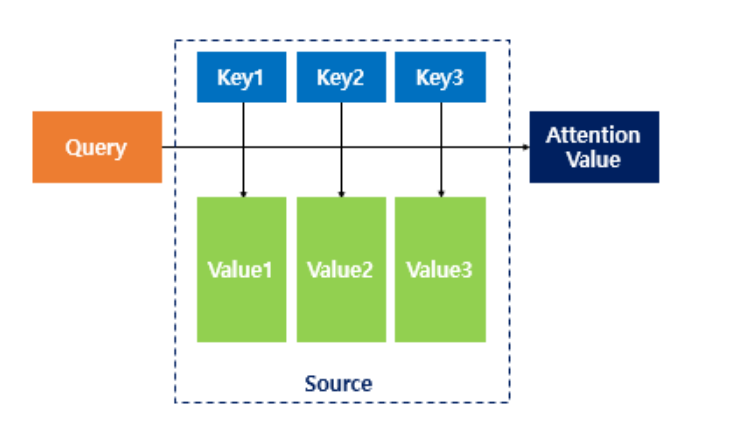

어텐션을 함수로 표현하면 주로 다음과 같이 표현됩니다.

__Attention(Q, K, V) = Attention Value__

어텐션 함수는 주어진 **'쿼리(Query)'** 에 대해서 모든 **'키(Key)'와의 유사도** 를 각각 구합니다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 **'값(Value)'에 반영** 해줍니다. 그리고 **유사도가 반영된 '값(Value)'을 모두 더해서 리턴** 합니다. 여기서는 이를 **어텐션 값(Attention Value)** 이라고 하겠습니다.

지금부터 배우게 되는 seq2seq + 어텐션 모델에서 **Q, K, V** 에 해당되는 각각의 Query, Keys, Values는 각각 다음과 같습니다.

```yaml
    Q = Query : t 시점의 디코더 셀에서의 은닉 상태
    K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
    V = Values : 모든 시점의 인코더 셀의 은닉 상태들
```
간단한 어텐션 예제를 통해 어텐션을 이해해보겠습니다.

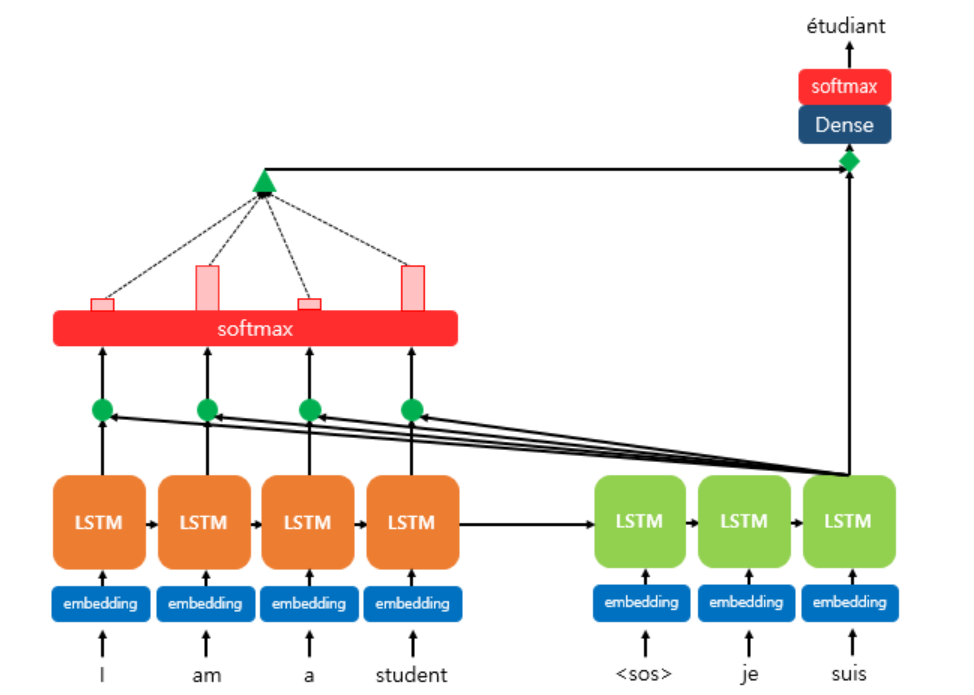

위 그림은 디코더의 세번째 LSTM 셀에서 출력 단어를 예측할 때, 어텐션 메커니즘을 사용하는 모습을 보여줍니다. 디코더의 첫번째, 두번째 LSTM 셀은 이미 어텐션 메커니즘을 통해 je와 suis를 예측하는 과정을 거쳤다고 가정합니다. 어텐션 메커니즘에 대해 상세히 설명하기 전에 위의 그림을 통해 전체적인 개요만 이해해보겠습니다. 디코더의 세번째 LSTM 셀은 출력 단어를 예측하기 위해서 인코더의 모든 입력 단어들의 정보를 다시 한번 참고하고자 합니다. 중간 과정에 대한 설명은 현재는 생략하고 여기서 주목할 것은 인코더의 소프트맥스 함수입니다.

소프트맥스 함수를 통해 나온 결과값은 I, am, a, student 단어 각각이 출력 단어를 예측할 때 얼마나 도움이 되는지의 정도를 수치화한 값입니다. 위의 그림에서는 빨간 직사각형의 크기로 소프트맥스 함수의 결과값의 크기를 표현했습니다. 직사각형의 크기가 클 수록 도움이 되는 정도의 크기가 큽니다. 각 입력 단어가 디코더의 예측에 도움이 되는 정도가 수치화하여 측정되면 이를 하나의 정보로 담아서 디코더로 전송됩니다. 위의 그림에서는 초록색 삼각형이 이에 해당됩니다. 결과적으로, 디코더는 출력 단어를 더 정확하게 예측할 확률이 높아집니다. 좀 더 상세히 알아보겠습니다.

#### **1) 어텐션 스코어(Attention Score)를 구한다.**
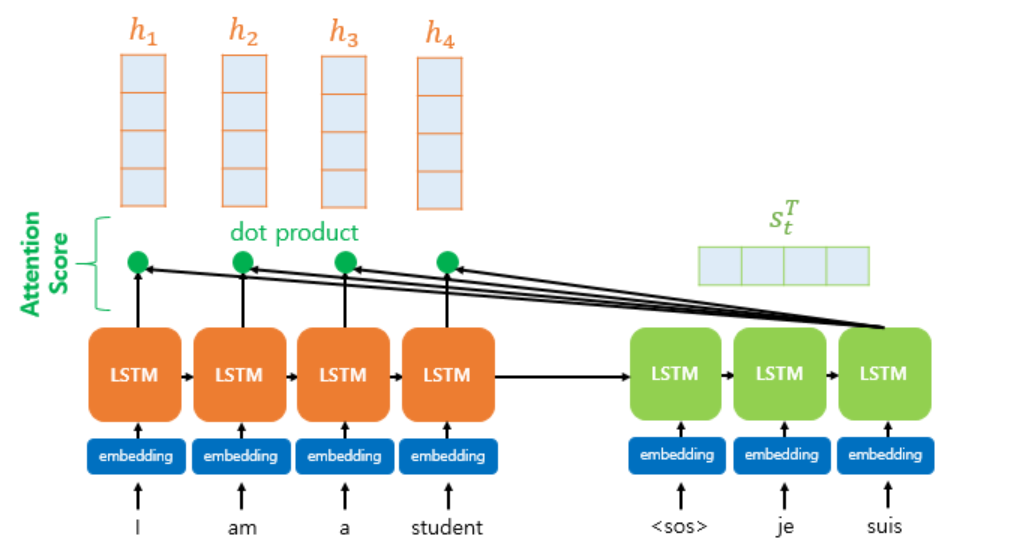

인코더의 시점(time step)을 각각 1, 2, ... N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 $h_1$, $h_2$, ... $h_N$라고 합시다. **디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)** 를 $s_t$라고 합시다. 또한 여기서는 인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정합니다. 위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4입니다.

어텐션 메커니즘의 첫 걸음인 어텐션 스코어(Attention score)에 대해서 배우기전에, 이전 챕터 배웠던 디코더의 현재 시점 t에서 필요한 입력값을 다시 상기해보겠습니다. 시점 t에서 출력 단어를 예측하기 위해서 디코더의 셀은 두 개의 입력값을 필요로 하는데, 바로 이전 시점인 t-1의 은닉 상태와 이전 시점 t-1에 나온 출력 단어입니다.

그런데 어텐션 메커니즘에서는 출력 단어 예측에 또 다른 값을 필요로 하는데 바로 **어텐션 값(Attention Value)** 이라는 새로운 값입니다. **t번째 단어를 예측하기 위한 어텐션 값을 $a_{t}$** 이라고 정의하겠습니다.

어텐션 값이라는 새로운 개념이 등장한 만큼, 어텐션 값이 현재 시점 t에서의 출력 예측에 구체적으로 어떻게 반영되는지는 뒤에서 설명하겠습니다. 지금부터 배우는 모든 과정은 $a_{t}$를 구하기 위한 여정입니다. 그리고 그 여정의 첫 걸음은 바로 어텐션 스코어(Attention Score)를 구하는 일입니다. 어텐션 스코어란 현재 디코더의 시점 t에서 단어를 예측하기 위해, **인코더의 모든 은닉 상태 각각이 디코더의 현 시점의 은닉 상태 $s_{t}$와 얼마나 유사한지** 를 판단하는 스코어값입니다.

닷-프로덕트 어텐션에서는 이 스코어 값을 구하기 위해 **$s_{t}$를 전치(transpose)** 하고 각 은닉 상태와 **내적(dot product)** 을 수행합니다. 즉, 모든 어텐션 스코어 값은 스칼라입니다. 예를 들어 $s_{t}$과 인코더의 i번째 은닉 상태의 어텐션 스코어의 계산 방법은 아래와 같습니다.


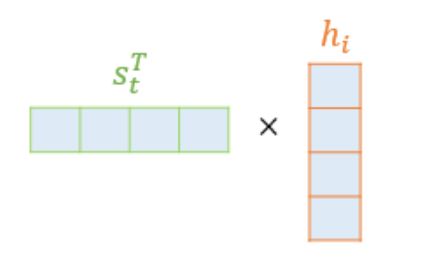
  
어텐션 스코어 함수를 정의해보면 다음과 같습니다.

##### $score(s_t, h_i) = s_t^T h_i$  
  
$s_t$와 인코더의 모든 은닉 상태의 **어텐션 스코어의 모음값** 을 라고 정의하겠습니다. 의 수식은 다음과 같습니다. 

##### $e^{t}=[s_{t}^Th_{1},...,s_{t}^Th_{N}]$


#### **2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.**

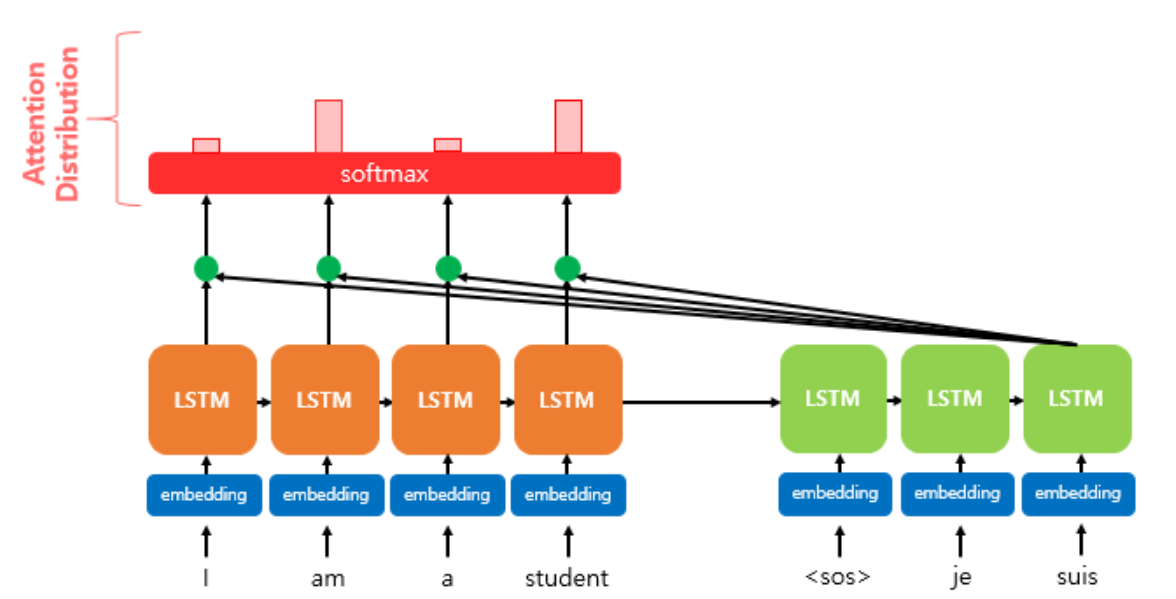

$e^T$에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 **어텐션 분포(Attention Distribution)** 라고 하며, 각각의 값은 **어텐션 가중치(Attention Weight)** 라고 합니다. 예를 들어 소프트맥스 함수를 적용하여 얻은 출력값인 I, am, a, student의 어텐션 가중치를 각각 0.1, 0.4, 0.1, 0.4라고 합시다. 이들의 합은 1입니다. 위의 그림은 각 인코더의 은닉 상태에서의 어텐션 가중치의 크기를 직사각형의 크기를 통해 시각화하였습니다. 즉, 어텐션 가중치가 클수록 직사각형이 큽니다.

**디코더의 시점 t에서의** 어텐션 가중치의 모음값인 **어텐션 분포** 를 $\alpha^t$이라고 할 때, $\alpha^t$을 식으로 정의하면 다음과 같습니다.
  
##### $\alpha^t = softmax(e^t)$

#### **3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.**
  
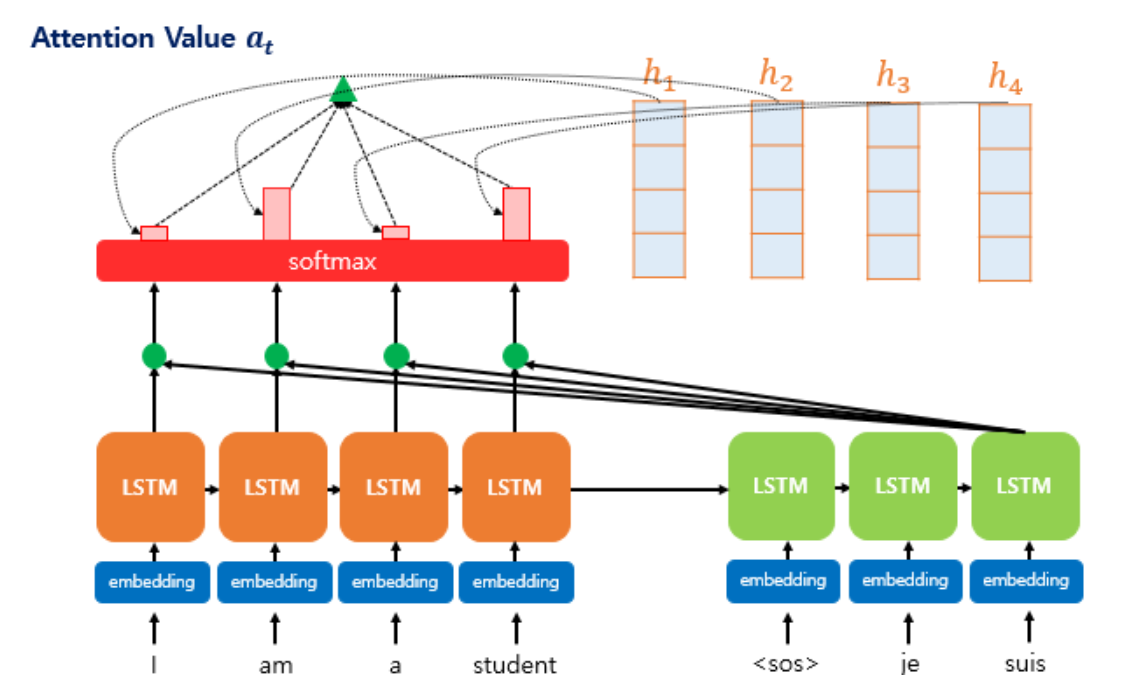

이제 지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 **가중합(Weighted Sum)** 을 진행합니다. 아래는 어텐션의 최종 결과. 즉, 어텐션 함수의 출력값인 **어텐션 값(Attention Value) $a_t$** 에 대한 식을 보여줍니다.

##### $$a_t = \sum_{i=1}^N \alpha_i^t h_i$$

이러한 **어텐션 값 $a_t$** 은 종종 인코더의 문맥을 포함하고 있다고하여, **컨텍스트 벡터(context vector)** 라고도 불립니다. 앞서 배운 가장 기본적인 seq2seq에서는 인코더의 마지막 은닉 상태를 컨텍스트 벡터라고 부르는 것과 대조됩니다.

#### **4) 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.(Concatenate)**

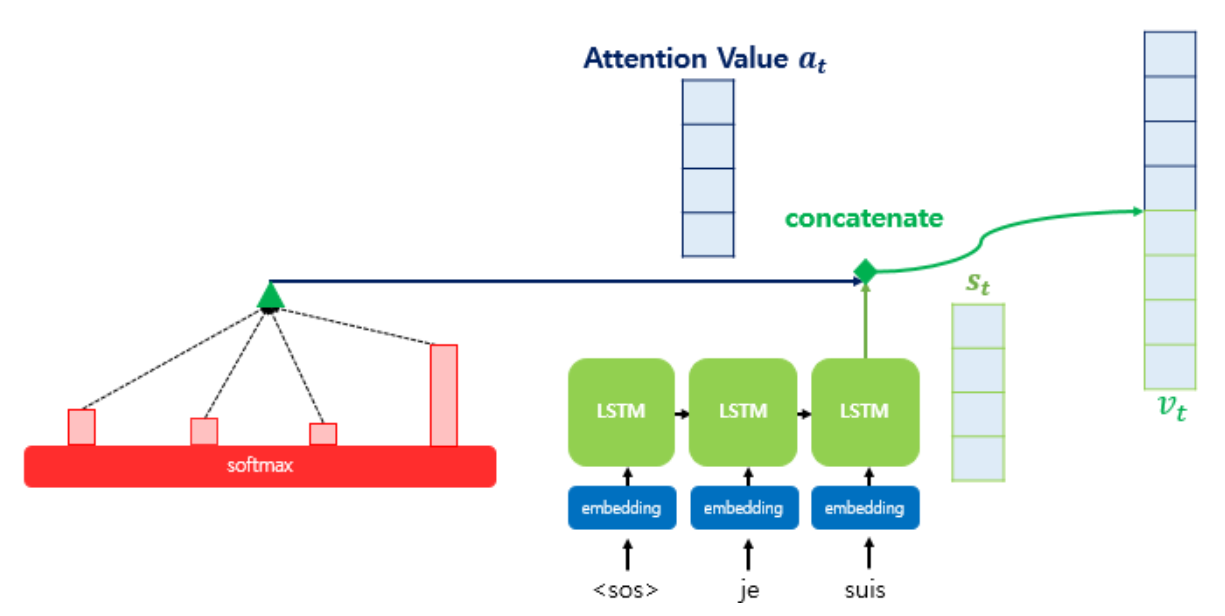

어텐션 함수의 최종값인 **어텐션 $a_t$값** 을 구했습니다. 사실 어텐션 값이 구해지면 어텐션 메커니즘은 **$a_t$를 $s_t$와 결합(concatenate)하여 하나의 벡터로 만드는 작업** 을 수행합니다. 이를 $v_t$라고 정의해보겠습니다. 그리고 이 $v_t$를 $\hat{y}$ 예측 연산의 입력으로 사용하므로서 인코더로부터 얻은 정보를 활용하여 
$\hat{y}$를 좀 더 잘 예측할 수 있게 됩니다. 이것이 어텐션 메커니즘의 핵심입니다.

#### **5) 출력층 연산의 입력이 되는 $\tilde{s}_t$ 를 계산합니다.**

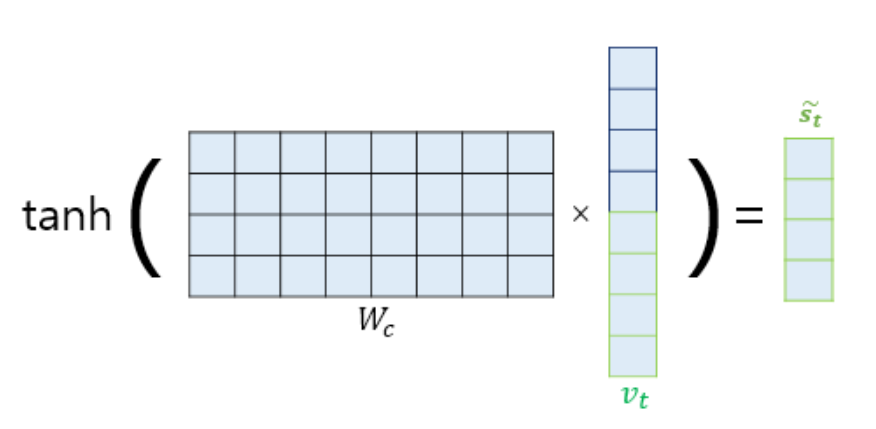

논문에서는 $v_t$를 바로 출력층으로 보내기 전에 신경망 연산을 한 번 더 추가하였습니다. 가중치 행렬과 곱한 후에 하이퍼볼릭탄젠트 함수를 지나도록 하여 출력층 연산을 위한 새로운 벡터인 $\tilde{s}_t$를 얻습니다. 어텐션 메커니즘을 사용하지 않는 seq2seq에서는 출력층의 입력이 t시점의 은닉 상태인 $s_t$였던 반면, 어텐션 메커니즘에서는 출력층의 입력이 $\tilde{s}_t$가 되는 셈입니다.

식으로 표현하면 다음과 같습니다. **$\mathbf{W_c}$** 는 학습 가능한 가중치 행렬, $b_c$는 편향입니다. 그림에서 편향은 생략했습니다.  
  
  $$\tilde{s}_{t} = \tanh(\mathbf{W_{c}}[{a}_t;{s}_t] + b_{c})$$

#### **6) $\tilde{s}_t$를 출력층의 입력으로 사용합니다.**
$\tilde{s}_t$를 출력층의 입력으로 사용하여 예측 벡터를 얻습니다.

##### $$\hat{y}_t = Softmax(W_y \tilde{s}_t + b_y)$$ 

---
### **4. 다양한 종류의 어텐션(Attention)**

앞서 seq2seq + 어텐션(attention) 모델에 쓰일 수 있는 다양한 어텐션 종류가 있지만, 닷-프로덕트 어텐션과 다른 어텐션들의 차이는 중간 수식의 차이라고 언급한 바 있습니다. 여기서 말하는 중간 수식은 어텐션 스코어 함수를 말합니다. 위에서 배운 어텐션이 닷-프로덕트 어텐션인 이유는 어텐션 스코어를 구하는 방법이 내적이었기 때문입니다.

어텐션 스코어를 구하는 방법은 여러가지가 제시되어있으며, 현재 제시된 여러 종류의 어텐션 스코어 함수는 다음과 같습니다.

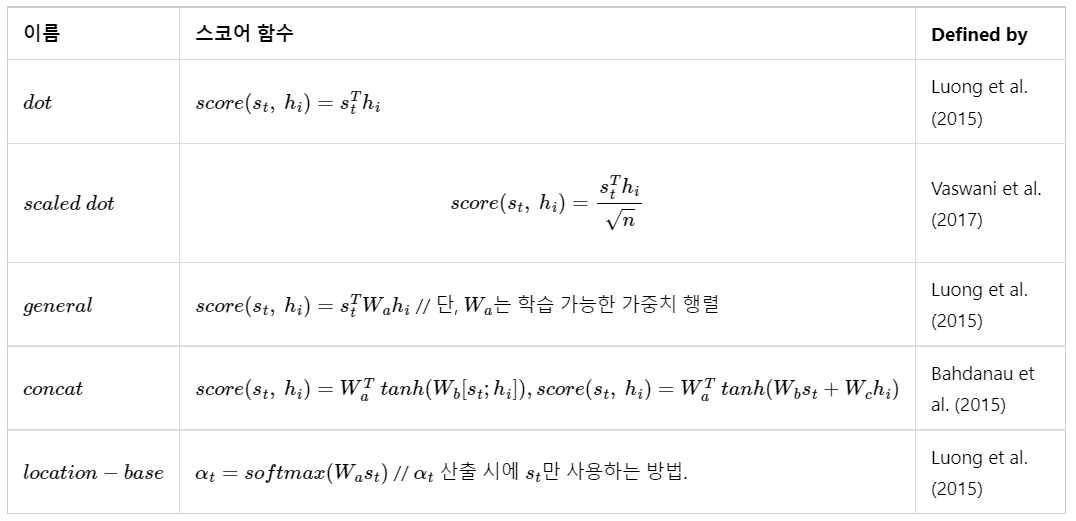

위에서 $s_t$는 Query, $h_i$는 Keys, $W_a$와 $W_b$는 **학습 가능한 가중치 행렬** 입니다.

이름이 dot이라고 붙여진 스코어 함수가 이번에 배운 **닷 프로덕트 어텐션** 입니다. 이 어텐션은 제안한 사람의 이름을 따서 **루옹(Luong) 어텐션** 이라고도 합니다. 제안한 이들의 이름은 위 테이블에서 Defined By에 적혀져 있습니다. concat이라는 이름의 어텐션은 만든 사람의 이름을 따서 **바다나우(Bahdanau) 어텐션** 이라고도 부르며 뒤에서 설명합니다.

지금까지 seq2seq에서 성능을 향상시켜주기 위한 기법인 어텐션에 대해서 알아봤습니다. 어텐션은 처음에는 RNN 기반의 seq2seq의 성능을 보정하기 위한 목적으로 소개되었지만, 현재에 이르러서는 어텐션 스스로가 기존의 seq2seq를 대체하는 방법이 되어가고 있습니다. 이에 대해서는 다음 챕터인 트랜스포머(Transformer) 챕터에서 더 자세히 배워보겠습니다.